In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gensim
import csv
import numpy as np
import pandas as pd

In [2]:
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim

In [3]:
from torch.utils.data.dataloader import default_collate

In [4]:
path = "/Users/lin/Desktop/2021RemoteTerm/NLP/group-project/data/"
model = gensim.models.KeyedVectors.load_word2vec_format(path+'model/GoogleNews-vectors-negative300.bin', binary=True)  

In [5]:
train_file = path+"train.csv"
test_file = path+"test.csv"

In [6]:
import nltk
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
import string
from nltk.corpus import stopwords
nltk.download("stopwords") 
// clean text and tokenize text
def tokenize(sentence):
    #sentence = "what single apple."
    if type(sentence) != str:
        return ''
    
    sentence = tknzr.tokenize(sentence)
    words = [w.lower() for w in sentence]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    return words
    

[nltk_data] Downloading package stopwords to /Users/lin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:

// map string to int
def label_pipeline(label):
    if label == "CryptoCurrency":
        return 0
    if label == "coronavirus":
        return 1
    if label == "cyberpunk":
        return 2
    if label == "jokes":
        return 3
    if label == "recipes":
        return 4
    if label == "Showerthoughts":
        return 5
    if label == "suicideanddepression":
        return 6
    if label =="texas":
        return 7
    if label == "wallstreetbets":
        return 8
    
#Average layer
#get average of the vector of a sentence
def text_pipeline(sentence):
    sentence = tokenize(sentence)
    #sentence = ['What','single','apple']
    array = np.zeros(model['good'].size)
    lenth = 0
    for w in sentence:
        if(w in model):
            array += model[w]
        lenth+=1
    if lenth >0:
        array = array/len(sentence)
    
    #print (x_np.shape)
    return array



In [8]:
device = torch.device('cpu')
input_size = 300
num_classes = 9
batch_size = 64
num_epochs = 1 
learning_rate = 1e-3

In [77]:
//custom dataset
class TextDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        
        self.df = pd.read_csv(file_path)
        #self.transform = transform
        #self.target_transform = target_transform
        self.label = self.df['subreddit']
        self.text = self.df['text']
        
    def __len__(self):
        lens = len(self.df)
        return lens

    def __getitem__(self, idx):
        
        label_id = self.label[idx]
        
        text = self.text[idx]
        
        label = label_pipeline(label_id)
        
        numericalized_text = text_pipeline(text)
        
        sample = [numericalized_text,label]
        
        return sample
    
def collate_batch(batch):
        batch = list(filter(lambda x:x[0] is not None, batch))
        batch = list(filter(lambda x:x[1] is not None, batch))
        if len(batch) == 0: 
            return "empty"
        return default_collate(batch)
def get_loader(file,
               transform,
               batch_size=32,
               num_workers=8,
               shuffle=False,
               collate_fn = collate_batch,
               pin_memory=False):
    dataset = TextDataset(file)
    loader = DataLoader(dataset=dataset,shuffle=shuffle,batch_size=batch_size,collate_fn=collate_fn)
    return loader


In [78]:
train_dataset = get_loader(train_file,transform=None)
test_dataset = get_loader(test_file,transform=None)

In [11]:
testset = TextDataset(train_file)

In [123]:
//model defination
class Net(nn.Module):

    def __init__(self,input_size,num_classes):#(1x300, 9 classes )
        super(Net, self).__init__()
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_size, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        

    def forward(self, x):
        # Max pooling over a (2, 2) window
 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net(300,9).to(device)

print(net)

Net(
  (fc1): Linear(in_features=300, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)


In [101]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=learning_rate)

In [102]:
import matplotlib.pyplot as plt

In [103]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [121]:
#train

def train(dataset, num_epochs, net):
    size = len(train_dataset.dataset)
    loss_vals = []
    epoch_loss= []
    for epoch in range(num_epochs):
        
        indices = []
        for batch_indx,sample_batched in enumerate (dataset):
            if sample_batched == 'empty':
                continue
            if len(sample_batched) !=2:
                continue
            text = sample_batched[0].to(device=device)
            
            label = sample_batched[1].to(device = device)
            pred = net(text.float())
            loss = loss_fn(pred, label)
            optimizer.zero_grad()
            loss.backward()
            indices.append(batch_indx)
            epoch_loss.append(loss.item())
            optimizer.step()

            if batch_indx % 5000 == 0:
                loss, current = loss.item(), batch_indx * len(sample_batched[0])
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                plt.plot(indices, epoch_loss)
                plt.show()
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))


loss: 2.238689  [    0/3059548]


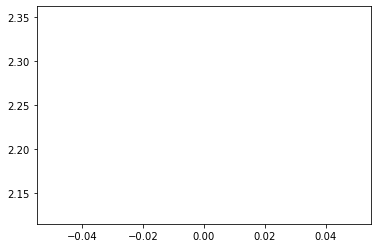

loss: 0.635791  [160000/3059548]


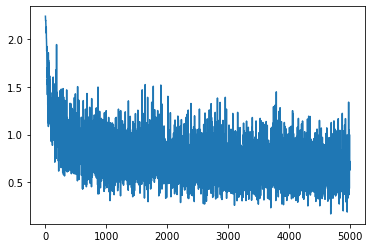

loss: 0.982578  [320000/3059548]


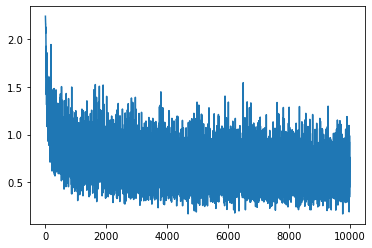

loss: 0.696929  [480000/3059548]


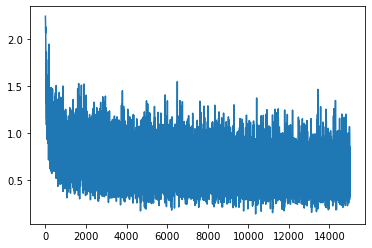

loss: 0.470227  [640000/3059548]


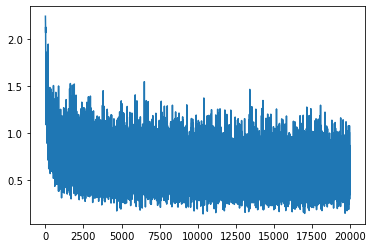

loss: 0.636186  [800000/3059548]


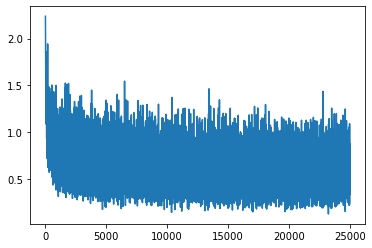

loss: 0.542075  [960000/3059548]


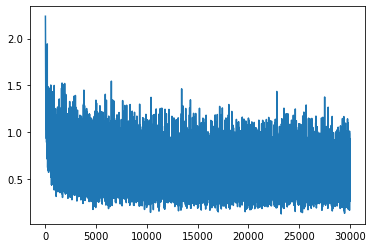

loss: 0.619574  [1120000/3059548]


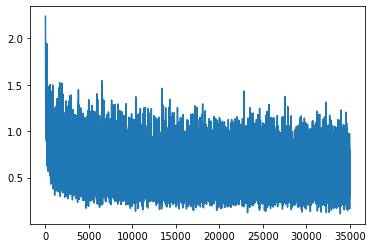

loss: 0.547549  [1280000/3059548]


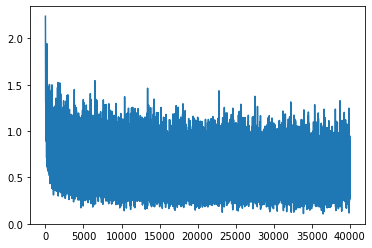

loss: 0.754343  [1440000/3059548]


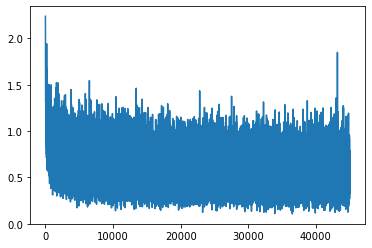

loss: 0.385338  [1600000/3059548]


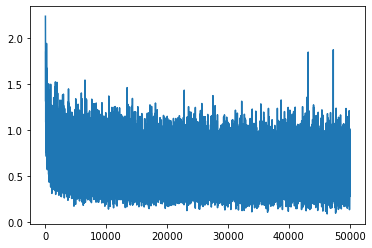

loss: 0.256200  [1760000/3059548]


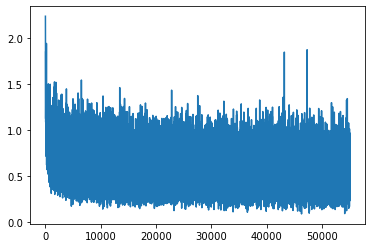

loss: 0.400405  [1920000/3059548]


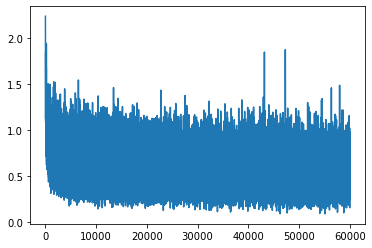

loss: 0.553386  [2080000/3059548]


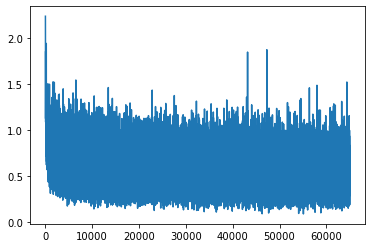

loss: 0.517407  [2240000/3059548]


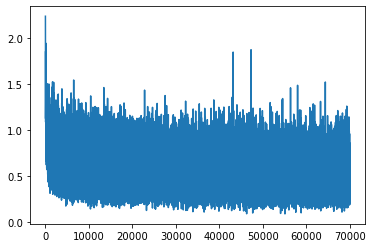

loss: 0.429450  [2400000/3059548]


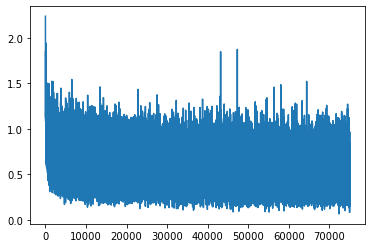

loss: 0.533977  [2560000/3059548]


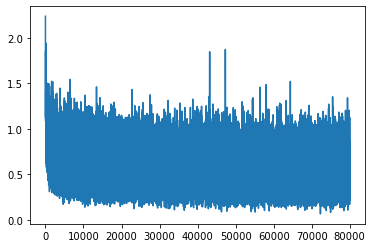

loss: 0.430393  [2720000/3059548]


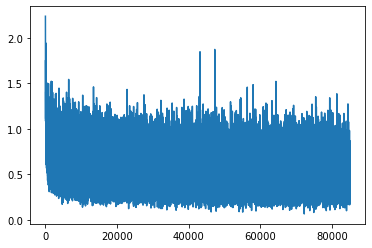

loss: 0.495142  [2880000/3059548]


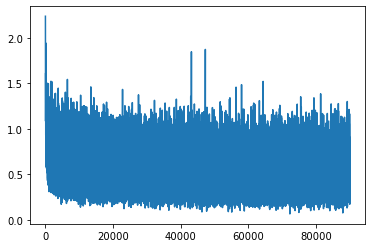

loss: 0.776536  [3040000/3059548]


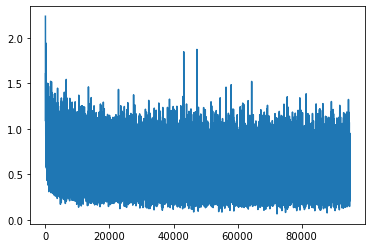

In [105]:
train(train_dataset, 1,net)

In [106]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for  batch_indx,sample_batched in enumerate (dataloader):
            if sample_batched == 'empty':
                continue
            if len(sample_batched) !=2:
                continue
            text = sample_batched[0].to(device=device)
            label = sample_batched[1].to(device = device)
            pred = model(text.float())
            test_loss += loss_fn(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [107]:
import torch.onnx as onnx
import torchvision.models as models
torch.save(net.state_dict(), path+'model_weights.pth')

In [108]:
test(test_dataset, net)

Test Error: 
 Accuracy: 82.7%, Avg loss: 0.016244 



In [115]:
text = text_pipeline("where can I get a vaccine?")
text = torch.Tensor(text).to(device=device)
pred = net(text.float())
print(pred)
testNet = Net(300,9).to(device)
predtest = testNet(text.float())
print(predtest)

tensor([ -3.4857,   3.8068,  -5.5581,  -9.8207, -78.0464,   2.9763,  -7.4932,
          1.0202, -10.5082], grad_fn=<AddBackward0>)
tensor([-0.0658, -0.1084,  0.0818, -0.0191,  0.0923, -0.0868, -0.0672,  0.0027,
         0.0245], grad_fn=<AddBackward0>)


loss: 2.238844  [    0/3059548]


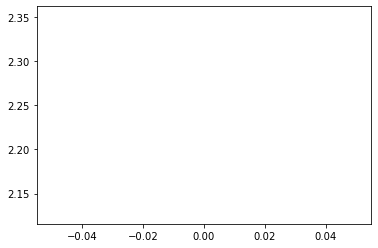

loss: 2.230767  [160000/3059548]


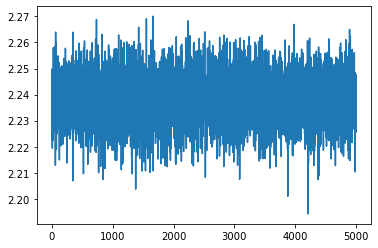

loss: 2.233604  [320000/3059548]


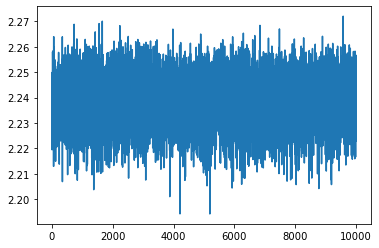

loss: 2.250909  [480000/3059548]


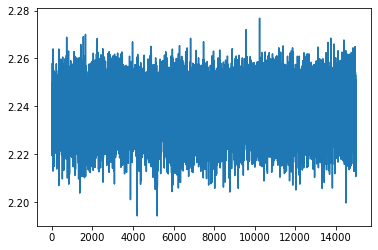

loss: 2.233270  [640000/3059548]


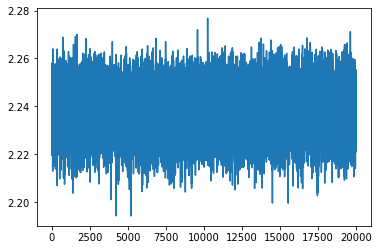

loss: 2.217425  [800000/3059548]


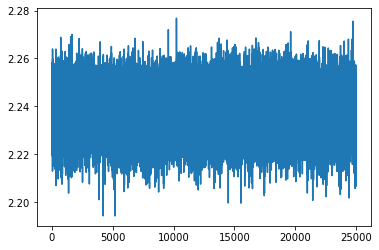

loss: 2.236972  [960000/3059548]


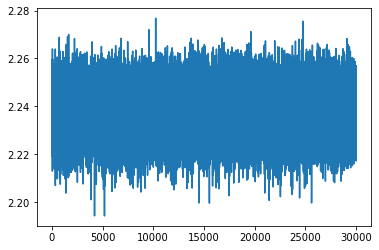

loss: 2.247916  [1120000/3059548]


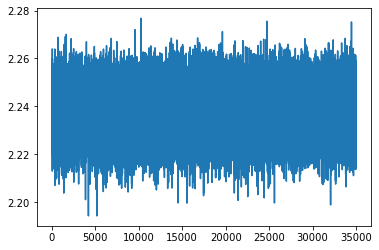

loss: 2.239171  [1280000/3059548]


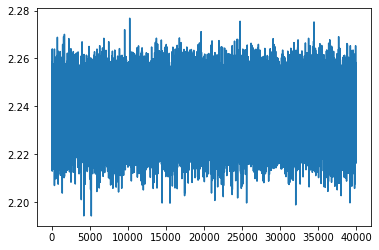

loss: 2.223950  [1440000/3059548]


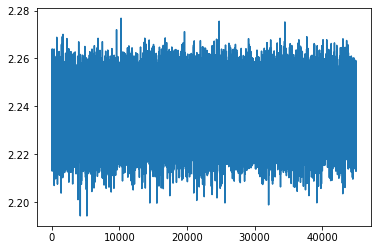

loss: 2.236987  [1600000/3059548]


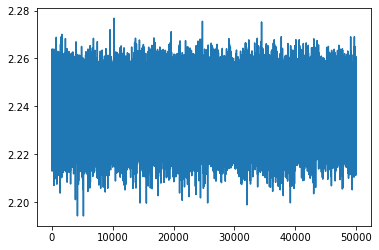

loss: 2.253035  [1760000/3059548]


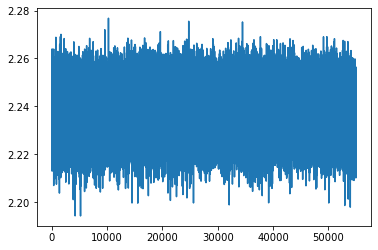

loss: 2.238209  [1920000/3059548]


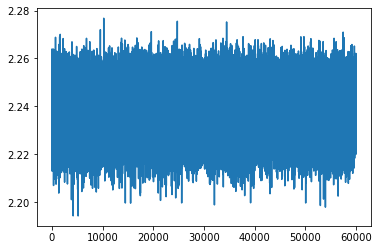

loss: 2.243728  [2080000/3059548]


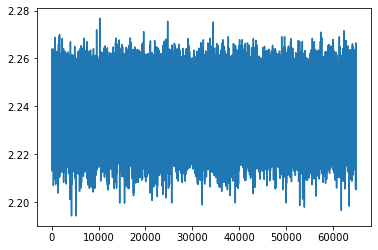

loss: 2.222525  [2240000/3059548]


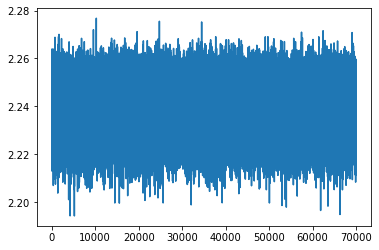

loss: 2.233535  [2400000/3059548]


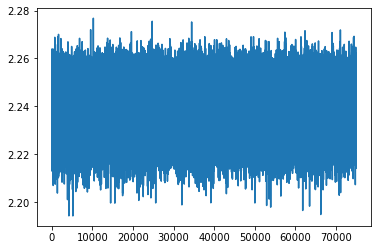

loss: 2.233225  [2560000/3059548]


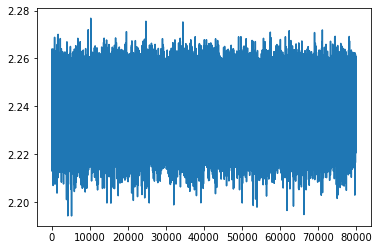

loss: 2.249568  [2720000/3059548]


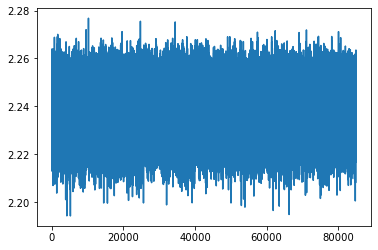

loss: 2.249550  [2880000/3059548]


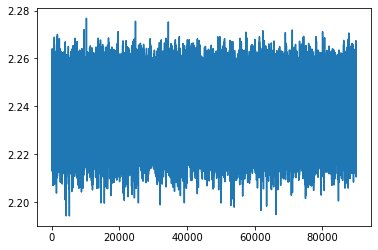

loss: 2.219649  [3040000/3059548]


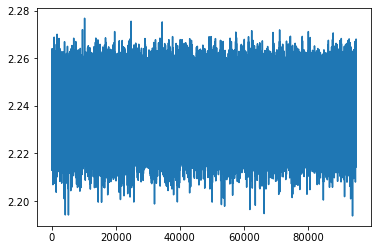

Test Error: 
 Accuracy: 3.5%, Avg loss: 0.069958 



In [127]:
test(test_dataset, testNet)

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.070005 

